# Loading the data

In [36]:
import io
import pandas as pd
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm
from copy import deepcopy


import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.optim as optim
from torch import nn
from sklearn.calibration import LabelEncoder
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset

# set seed 
seed = 0
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [37]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [38]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17112 entries, 0 to 17111
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 17112 non-null  int64  
 1   budget                17112 non-null  int64  
 2   genres                17072 non-null  object 
 3   original_language     17112 non-null  object 
 4   overview              17112 non-null  object 
 5   popularity            17112 non-null  float64
 6   production_companies  15769 non-null  object 
 7   production_countries  16637 non-null  object 
 8   revenue               17112 non-null  int64  
 9   runtime               17112 non-null  float64
 10  spoken_languages      16971 non-null  object 
 11  status                17112 non-null  object 
 12  tagline               17112 non-null  object 
 13  video                 17112 non-null  int64  
 14  vote_average          17112 non-null  float64
 15  vote_count         

In [39]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])  # Replace with your target column

In [40]:

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Encode the overview and tagline columns
overview_encoded = tfidf_vectorizer.fit_transform(df['overview']).toarray()
overview_encoded_df = pd.DataFrame(overview_encoded, columns=tfidf_vectorizer.get_feature_names_out())

tagline_encoded = tfidf_vectorizer.fit_transform(df['tagline']).toarray()
tagline_encoded_df = pd.DataFrame(tagline_encoded, columns=tfidf_vectorizer.get_feature_names_out())


## Encode cast

In [41]:
# Get list of all unique names in df[`cast`]
df['cast'] = df['cast'].replace(np.nan, '')
unique_cast = df['cast'].str.split(',').explode()
unique_cast.value_counts()
# Take only actors that appeared in more than 10 movies
top_cast = unique_cast.value_counts()[unique_cast.value_counts() > 10]

df['cast'] = df['cast'].apply(lambda x: [i for i in x.split(',') if i in top_cast.index]).apply(lambda x: ','.join(x))

In [42]:
print(df['cast'])

0        Charlie Sheen,Whoopi Goldberg,Luis Guzmán,Gina...
1                Carla Gugino,Marley Shelton,Ellen Burstyn
2                         Dominique Swain,Christine Nguyen
3                     Tom Arnold,Simon Rex,Laura Cayouette
4        Sandra Bullock,Thomas Haden Church,Bradley Coo...
                               ...                        
17107                            Larry Pine,Dakota Fanning
17108                                                     
17109                                              Gong Li
17110                                                     
17111    François Cluzet,Jane Seymour,Jean-François Bal...
Name: cast, Length: 17112, dtype: object


## Encode production companies

In [52]:
df['production_companies'] = df['production_companies'].replace(np.nan, '')
unique_production_companies = df['production_companies'].str.split(',').explode()
unique_production_companies.value_counts()

top_companies = unique_production_companies.value_counts()[unique_production_companies.value_counts() > 10]
df['production_companies'] = df['production_companies'].apply(lambda x: [i for i in x.split(',') if i in top_companies.index]).apply(lambda x: ','.join(x))


0


## Encode directors

In [58]:
df['directors'] = df['directors'].replace(np.nan, '')
unique_directors = df['directors'].str.split(',').explode()
unique_directors.value_counts()

top_directors = unique_directors.value_counts()[unique_directors.value_counts() > 10]
df['directors'] = df['directors'].apply(lambda x: [i for i in x.split(',') if i in top_directors.index]).apply(lambda x: ','.join(x))

In [59]:
from sklearn.preprocessing import MultiLabelBinarizer

# Function to preprocess the column
def preprocess_column(column):
    # Split the strings into lists
    return column.fillna('').str.split(',')

# Function to encode a list column with MultiLabelBinarizer
def encode_column(column):
    mlb = MultiLabelBinarizer()
    return mlb.fit_transform(preprocess_column(column)), mlb.classes_

# Encoding list-based features
genres_encoded, genres_classes = encode_column(df['genres'])
production_companies_encoded, companies_classes = encode_column(df['production_companies'])
production_countries_encoded, countries_classes = encode_column(df['production_countries'])
cast_encoded, cast_classes = encode_column(df['cast'])
directors_encoded, directors_classes = encode_column(df['directors'])

# Create DataFrames for the encoded list columns
genres_encoded_df = pd.DataFrame(genres_encoded, columns=genres_classes)
production_companies_encoded_df = pd.DataFrame(production_companies_encoded, columns=companies_classes)
production_countries_encoded_df = pd.DataFrame(production_countries_encoded, columns=countries_classes)
cast_encoded_df = pd.DataFrame(cast_encoded, columns=cast_classes)
directors_encoded_df = pd.DataFrame(directors_encoded, columns=directors_classes)

print(genres_encoded_df.shape)
print(production_companies_encoded_df.shape)
print(production_countries_encoded_df.shape)
print(cast_encoded_df.shape)
print(directors_encoded_df.shape)


(17112, 20)
(17112, 457)
(17112, 136)
(17112, 3283)
(17112, 118)


In [61]:
unencoded_df = df[['adult', 'budget', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month', 'release_day']]
final_df = pd.concat([overview_encoded_df, tagline_encoded_df, genres_encoded_df, cast_encoded_df, 
                      production_companies_encoded_df, production_countries_encoded_df, directors_encoded_df, unencoded_df], axis=1)

# NN

In [62]:
X = final_df
Y = df['category']

In [63]:
print(X.shape)
print(overview_encoded_df.shape)

(17112, 54096)
(17112, 42219)


In [64]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [65]:
# Create a custom Dataset class
class MovieDataset(Dataset):
    def __init__(self, features, labels):
        # Convert features to a NumPy array if it's a DataFrame
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()  # Convert DataFrame to NumPy array
        
        self.X = torch.tensor(features, dtype=torch.float32)  # Convert features to tensor
        self.y = torch.tensor(labels, dtype=torch.long)       # Convert labels to tensor

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Assuming X_train and Y_train are your features and labels DataFrames
# Convert Y_train to a NumPy array if it's also a DataFrame
if isinstance(Y_train, pd.Series):
    Y_train = Y_train.to_numpy()

if isinstance(Y_test, pd.Series):
    Y_test = Y_test.to_numpy()

# Create Dataset objects
train_dataset = MovieDataset(X_train, Y_train)
test_dataset = MovieDataset(X_test, Y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)           # Second hidden layer
        self.fc3 = nn.Linear(64, num_classes)   # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_train.shape[1]  # Number of input features
num_classes = len(np.unique(Y_train))  # Number of classes in the target
model = SimpleNN(input_size, num_classes)


In [66]:
# Define the neural network
class MovieClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MovieClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(512, 128)           # Second hidden layer with 64 neurons
        self.fc3 = nn.Linear(128, 64)            # Third hidden layer with 32 neurons
        self.fc4 = nn.Linear(64, 16)            # Fourth hidden layer with 16 neurons
        self.output = nn.Linear(16, num_classes) # Output layer

        # Activation function
        self.relu = nn.ReLU()
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.output(x)  # Output layer (logits)
        return x
    
# Initialize the model
input_size = X_train.shape[1]  # Number of input features
num_classes = len(np.unique(Y_train))  # Number of classes in the target
model = MovieClassifier(input_size, num_classes)

In [67]:
# Set the device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 37.6963
Epoch [2/10], Loss: 1.3810
Epoch [3/10], Loss: 1.3898
Epoch [4/10], Loss: 1.3958
Epoch [5/10], Loss: 1.3853
Epoch [6/10], Loss: 1.3892
Epoch [7/10], Loss: 1.3830
Epoch [8/10], Loss: 1.3817
Epoch [9/10], Loss: 1.3881
Epoch [10/10], Loss: 1.3840


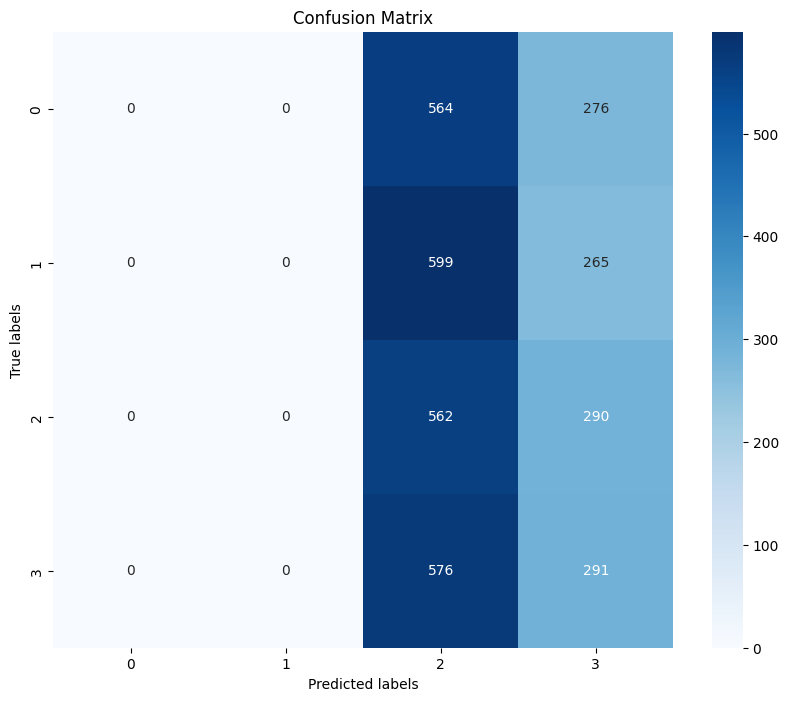

In [69]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [73]:
# Get value counts from the test loader
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get the value counts
true_counts = np.unique(y_true, return_counts=True)[1]
pred_counts = np.unique(y_pred, return_counts=True)[1]
print('True counts:', true_counts)
print('Predicted counts:', pred_counts)

True counts: [840 864 852 867]
Predicted counts: [2301 1122]
